In [1]:
from cirq_sic import *
from cirq.contrib.svg import SVGCircuit

import numpy as np
np.set_printoptions(precision=3, suppress=True)

import matplotlib.pyplot as plt

In [2]:
processor_id = "willow_pink"
globals().update(get_device_data(processor_id))

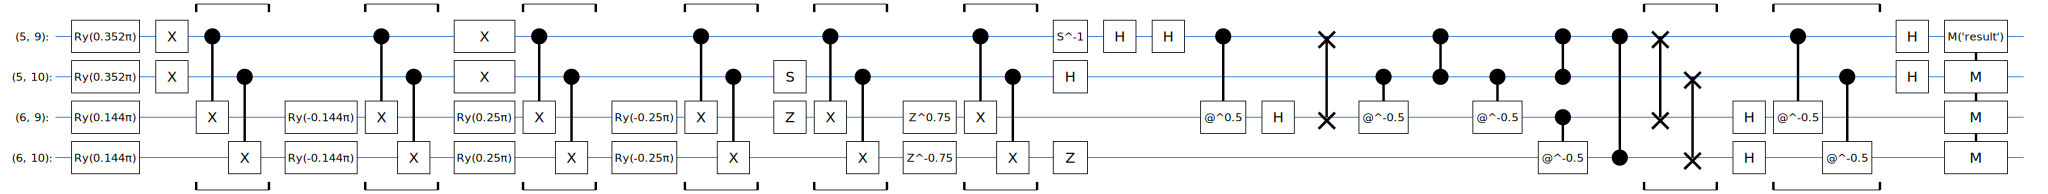

In [3]:
n = 2
A = [cirq.GridQubit(5,9), cirq.GridQubit(6,9)]
B = [cirq.GridQubit(5,10), cirq.GridQubit(6,10)]  

# 1) Prepare fiducial in A (system) and conjuate fiducial in B (ancilla).
# 2) Apply controlled shift (A: target, B: control)
# 3) Inverse fourier transform B. This implements the operator D.
# 4) Measuring in computational basis realize the WH-POVM.
circuit = cirq.Circuit((d4_sic_fiducial(A),\
                        simple_wh_povm(A, B, d4_sic_fiducial, measure=True)))
SVGCircuit(circuit)

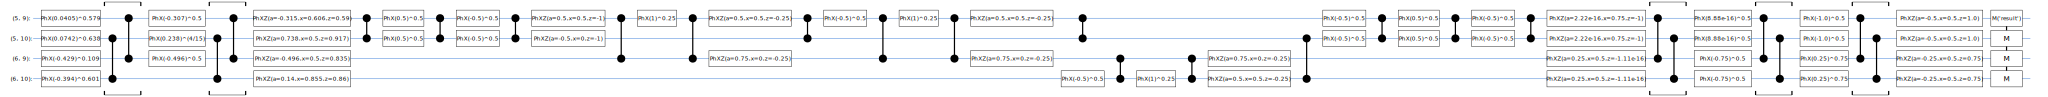

In [4]:
optimized_circuit = process_circuit(circuit, connectivity_graph, gateset, A+B)
device.validate_circuit(optimized_circuit)
SVGCircuit(optimized_circuit)

In [5]:
# Exact simulation
N = 50000
s = cirq.Simulator()
samples = s.run(optimized_circuit, repetitions=N)
counts = samples.histogram(key="result")
exact_freqs =  np.array([v for k, v in sorted(counts.items())])/N
exact_freqs

array([0.253, 0.052, 0.049, 0.05 , 0.051, 0.051, 0.05 , 0.049, 0.048,
       0.051, 0.048, 0.05 , 0.05 , 0.049, 0.05 , 0.049])

In [6]:
# Direct calculation
d = 4
phi = d4_sic_fiducial_ket()
E = wh_povm(phi)
p = np.array([phi.conj() @ e @ phi for e in E]).real; p

array([0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05])

In [7]:
# Noisy simulation
N = 50000
samples = sampler.run(optimized_circuit, repetitions=N)
counts = samples.histogram(key="result")
noisy_freqs = np.array([v for k, v in sorted(counts.items())])/N

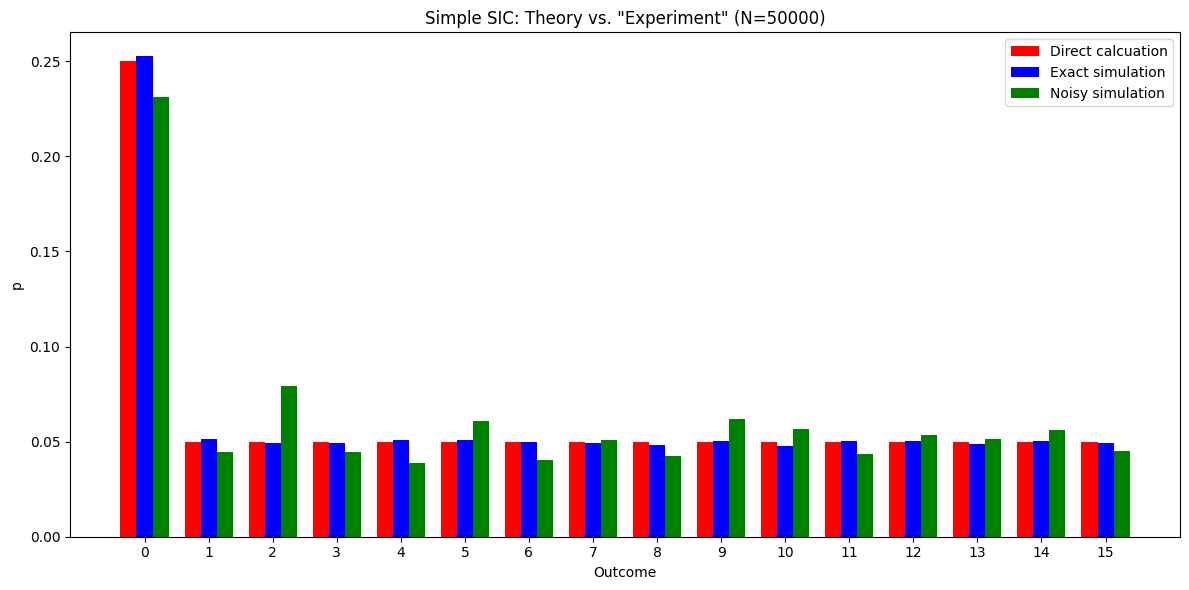

In [15]:
x_pos = np.arange(2**4) 
bar_width = 0.25
plt.figure(figsize=(12, 6))
plt.bar(x_pos - bar_width, p, width=bar_width, label='Direct calcuation', color='red')
plt.bar(x_pos, exact_freqs, width=bar_width, label='Exact simulation', color='blue')
plt.bar(x_pos + bar_width, noisy_freqs, width=bar_width, label='Noisy simulation', color='green')
plt.ylabel('p')
plt.xlabel('Outcome')
plt.title('Simple SIC: Theory vs. "Experiment" (N=%d)' % N)
plt.xticks(x_pos)
plt.legend()
plt.tight_layout()
plt.savefig("img/simple_theory_vs_experiment.pdf", bbox_inches='tight')

## Gate counts

In [16]:
simple_circuit = cirq.Circuit((simple_wh_povm(A, B, measure=False)))
get_gate_counts(simple_circuit)

--- Gate Counts (by type) ---
HPowGate: 6
CZPowGate: 9
SwapPowGate: 3


In [17]:
len(simple_circuit.moments)

13

In [18]:
get_gate_counts(optimized_circuit)

--- Gate Counts (by type) ---
PhasedXPowGate: 30
CZPowGate: 25
PhasedXZGate: 20
MeasurementGate: 1


In [19]:
len(optimized_circuit.moments)

41